## Betting strategy for 23-24 & 24-25 (first 3 matchweeks) seasons

After training the models on data up to the **2022-2023 season** and testing them on the **2023-2024 season**, we now aim to utilize their predictions to devise a **betting strategy** for the ongoing **2024-2025 season**.

Due to data constraints during the merging process, predictions are available only for the first **three matchweeks** of the 2024-2025 season. Nevertheless, these predictions provide a basis to compare the models in terms of their **profitability** when applied to a betting strategy.

It is important to emphasize that the primary objective of this project is not solely to predict match outcomes but rather to evaluate whether a **profitable betting strategy** can be implemented in the **short to medium term** based on these predictions. For this reason, we are more inclined to favor models that demonstrate higher **profitability** in this context.


### Strategy Overview

The implemented strategy involves placing a **1 euro bet** on the predicted match outcome: **Home Win (2)**, **Draw (1)**, or **Away Win (0)**. The betting odds are based on data provided by Bet365, with the following features included in the dataset: **B365H** (Home win odds), **B365D** (Draw odds), and **B365A** (Away win odds).


### Steps in the Analysis

1. **Import the Dataset and Pre-Trained Models**  
   - The dataset and trained models are loaded to make predictions for match outcomes.  
   - Predictions are generated for matches from both the **2023-2024 season** and the first **three matchweeks** of the **2024-2025 season**.

2. **Implement the Betting Strategy**  
   - Based on the predictions and corresponding Bet365 odds, a betting strategy is applied to determine profits or losses for each model.  

3. **Calculate Profits and ROI**  
   - By the last available match (end of matchweek 3 in the 2024-2025 season), the **profits** and **Return on Investment (ROI)** are calculated for each model, enabling a comparison of their effectiveness in the context of the betting strategy.




In [3]:
import pandas as pd
import numpy as np
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

DATA_PATH='data'

In [4]:
# Import Ml dataset

df = pd.read_csv('data/ML_data.csv')

In [5]:
# Load all trained-models saved as .pkl
def load_model(filepath):
    with open(filepath, "rb") as file:
        model = pickle.load(file)
    print(f"Model loaded from: {filepath}")
    return model

logistic_regression_simple = load_model(r"ML_models/logistic_regression_simple.pkl")
elastic_net_logistic = load_model(r"ML_models/logistic_regression_elastic_net.pkl")
random_forest_improved = load_model(r"ML_models/random_forest.pkl")
xgboost_improved = load_model(r"ML_models/xgboost_classifier.pkl")
lightgbm_improved = load_model(r"ML_models/lightgbm_improved.pkl")

Model loaded from: ML_models/logistic_regression_simple.pkl
Model loaded from: ML_models/logistic_regression_elastic_net.pkl
Model loaded from: ML_models/random_forest.pkl
Model loaded from: ML_models/xgboost_classifier.pkl
Model loaded from: ML_models/lightgbm_improved.pkl


In [6]:
# Let's consider only the 2024 2025 season

data_2324_2425 = df[df["Season"].isin([2324, 2425])]

def transform_results(results):
    transformed = []
    for i in range(len(results)):
        if results[i] == 'H':
            transformed.append(2)
        elif results[i] == 'A':
            transformed.append(0)
        else:
            transformed.append(1)
    return np.array(transformed)

data_2324_2425['FTR'] = transform_results(data_2324_2425['FTR'].values)
data_2324_2425 = data_2324_2425[[col for col in data_2324_2425 if col != 'FTR'] + ['FTR']] # Put FTR as last column
data_2324_2425.head()

C:\Users\giuse\AppData\Local\Temp\ipykernel_16128\4218036990.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2324_2425['FTR'] = transform_results(data_2324_2425['FTR'].values)


,gameId,Date,Season,HomeTeam,AwayTeam,B365H,B365D,B365A,HTGD,ATGD,...,f_halfTimeGoalsForAway,f_redsAgainstAway,f_redsForAway,f_shotsAgainstAway,f_shotsForAway,f_shotsOnTargetAgainstAway,f_shotsOnTargetForAway,f_yellowsAgainstAway,f_yellowsForAway,FTR
2657,2661,2023-08-19,2324,Empoli,Verona,2.25,3.20,3.30,-1.0,1.0,...,0.878741,0.380202,0.055139,8.222223,14.838305,2.982778,4.962988,3.340877,2.010090,0
2658,2662,2023-08-19,2324,Frosinone,Napoli,8.50,5.00,1.36,-2.0,2.0,...,0.424885,0.339549,0.149206,12.394047,13.573431,3.637107,3.773242,3.037709,2.073424,0
2659,2663,2023-08-19,2324,Genoa,Fiorentina,3.40,3.25,2.20,-3.0,3.0,...,1.155392,0.024445,0.122265,11.191305,11.600872,3.039399,4.399574,2.313015,2.445637,0
2660,2664,2023-08-19,2324,Inter,Monza,1.40,5.00,7.00,2.0,-2.0,...,0.273881,0.059066,0.004280,13.473796,11.600655,4.157935,3.698050,2.127577,2.627730,2
2661,2665,2023-08-20,2324,Roma,Salernitana,1.53,4.00,6.50,0.0,0.0,...,0.904445,0.066667,0.004700,11.605926,14.063831,4.145217,5.569176,1.638024,1.193371,1


In [7]:
# Separate features and target variable
Y_2324_2425 = data_2324_2425["FTR"]    
X_2324_2425 = data_2324_2425.drop(['gameId', 'Date', 'Season', 'HomeTeam', 'AwayTeam', "FTR"], axis=1)

total_bet = 1* X_2324_2425.shape[0]   # total amount bet
total_bet

409

In [8]:
# Funtion to compute the P&L for each match
def PandL(dataset, stake=1):
    """
    Adds two columns to the dataset: 
    1. 'W_L' (Win/Loss): Based on the comparison of 'Prediction' and 'FTR', 
       and calculated using the odds columns B365H, B365D, and B365A.
    2. 'P&L' (Profit and Loss): A cumulative sum of the 'W_L' column to track 
       profit and loss over time.

    Args:
        dataset (pd.DataFrame): The dataset with the columns 'Prediction', 'FTR', 
                                'B365H', 'B365D', and 'B365A'.
        stake (float): The base value to multiply by the odds. Default is 100.

    Returns:
        pd.DataFrame: The original dataset with two added columns: 'W_L' and 'P&L'.
    """
    # Initialize an empty list for W_L values
    wl = []
    
    # Iterate through the dataset rows
    for _, row in dataset.iterrows():
        if row['Prediction'] == row['FTR'] == 2:
            wl.append(stake * row['B365H'])
        elif row['Prediction'] == row['FTR'] == 1:
            wl.append(stake * row['B365D'])
        elif row['Prediction'] == row['FTR'] == 0:
            wl.append(stake * row['B365A'])
        else:
            wl.append(-stake)
    
    # Add the 'W_L' column to the dataset
    dataset['W_L'] = wl
    
    # Add the 'P&L' column as a cumulative sum of the 'W_L' column
    dataset['P&L'] = dataset['W_L'].cumsum()
    
    return dataset


C:\Users\giuse\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


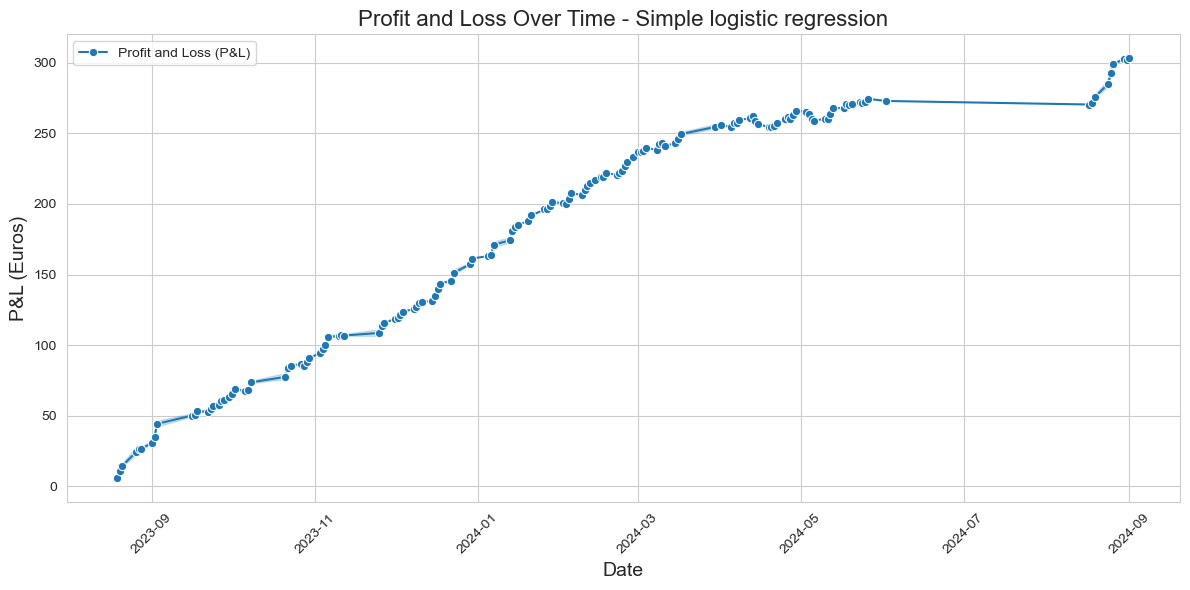

If you had placed a bet of 1 Euro on each match, starting from the first match of the 2023-2024 season and continuing until the last available match in the 2024-2025 season (for a total investment of 409 Euros), you would have achieved:
- Total profit: 303.93 Euros
- Return on Investment (ROI): 74.31%


In [9]:
# Logistic regression Simple
y_pred_logistic_regression_simple = logistic_regression_simple.predict(X_2324_2425)

data_lrs = data_2324_2425
data_lrs['Prediction'] = y_pred_logistic_regression_simple

tot_data_lrs = PandL(data_lrs, stake=1)
profit_lrs = tot_data_lrs['P&L'].iloc[-1]
ROI_lrs = (profit_lrs / total_bet)*100
PL_lrs = tot_data_lrs['P&L']

tot_data_lrs['Date'] = pd.to_datetime(tot_data_lrs['Date'])
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(data=tot_data_lrs, x='Date', y='P&L', marker='o', label='Profit and Loss (P&L)')

plt.title('Profit and Loss Over Time - Simple logistic regression', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('P&L (Euros)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

print(
    f"If you had placed a bet of 1 Euro on each match, starting from the first match of the "
    f"2023-2024 season and continuing until the last available match in the 2024-2025 season "
    f"(for a total investment of {total_bet} Euros), you would have achieved:\n"
    f"- Total profit: {profit_lrs:.2f} Euros\n"
    f"- Return on Investment (ROI): {ROI_lrs:.2f}%"
)

C:\Users\giuse\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


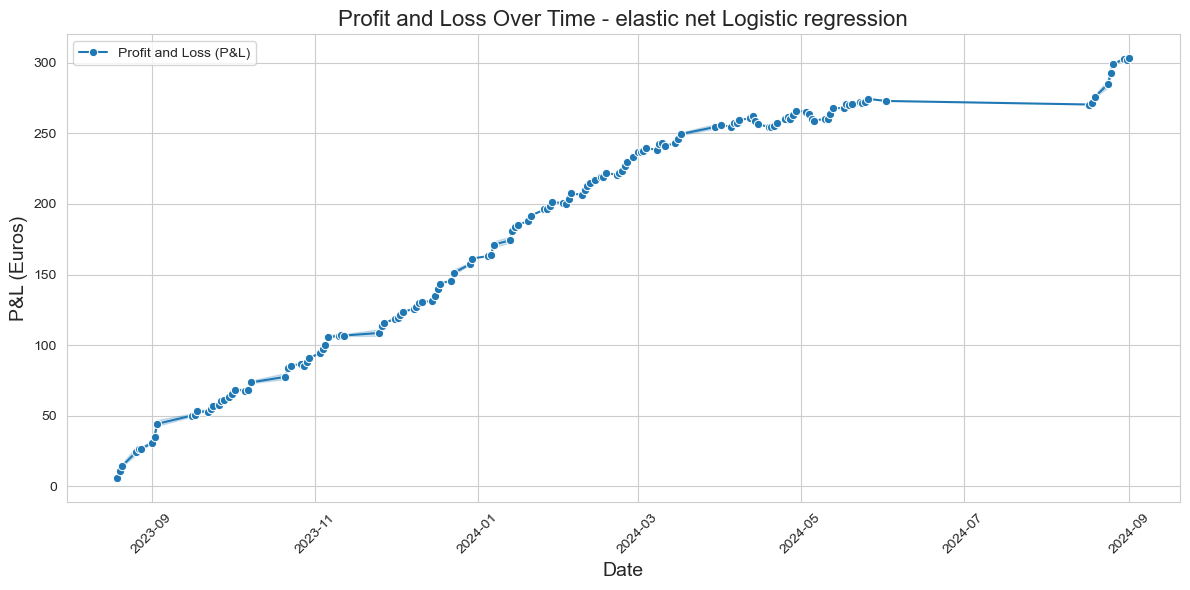

If you had placed a bet of 1 Euro on each match, starting from the first match of the 2023-2024 season and continuing until the last available match in the 2024-2025 season (for a total investment of 409 Euros), you would have achieved:
- Total profit: 303.93 Euros
- Return on Investment (ROI): 74.31%


In [10]:
# Logistic regression elastic net
y_pred_elastic_net_logistic = elastic_net_logistic.predict(X_2324_2425)

data_nl = data_2324_2425
data_nl['Prediction'] = y_pred_elastic_net_logistic

tot_data_nl = PandL(data_nl, stake=1)
profit_nl = tot_data_nl['P&L'].iloc[-1]
ROI_nl = (profit_nl / total_bet)*100
PL_nl = tot_data_nl['P&L']

tot_data_nl['Date'] = pd.to_datetime(tot_data_nl['Date'])
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(data=tot_data_nl, x='Date', y='P&L', marker='o', label='Profit and Loss (P&L)')

plt.title('Profit and Loss Over Time - elastic net Logistic regression', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('P&L (Euros)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

print(
    f"If you had placed a bet of 1 Euro on each match, starting from the first match of the "
    f"2023-2024 season and continuing until the last available match in the 2024-2025 season "
    f"(for a total investment of {total_bet} Euros), you would have achieved:\n"
    f"- Total profit: {profit_nl:.2f} Euros\n"
    f"- Return on Investment (ROI): {ROI_nl:.2f}%"
)

C:\Users\giuse\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


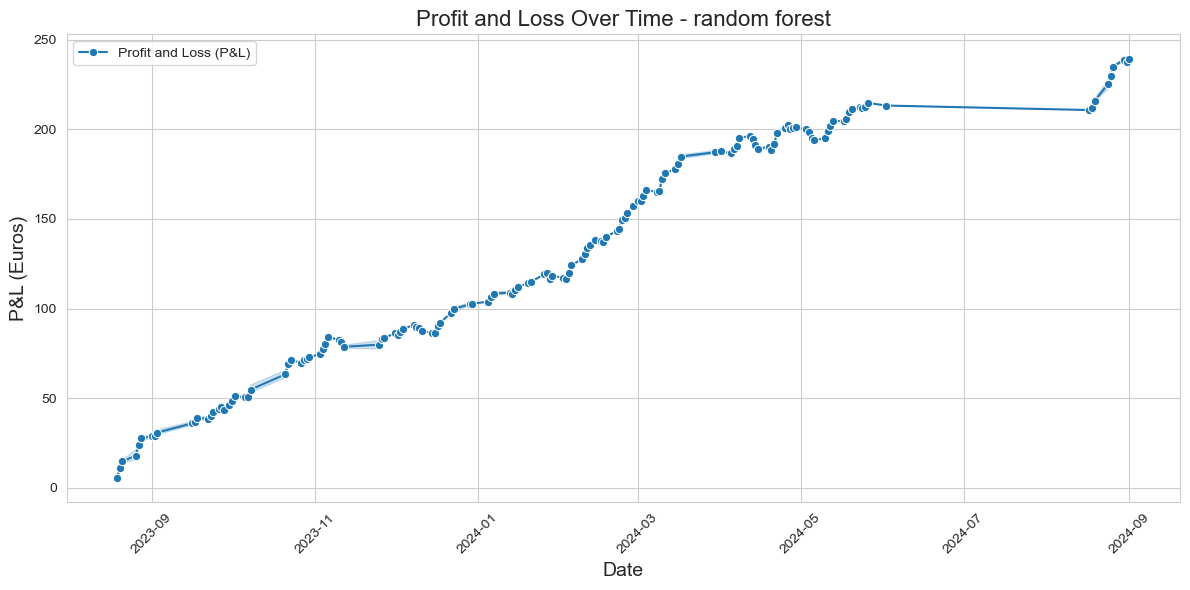

If you had placed a bet of 1 Euro on each match, starting from the first match of the 2023-2024 season and continuing until the last available match in the 2024-2025 season (for a total investment of 409 Euros), you would have achieved:
- Total profit: 240.08 Euros
- Return on Investment (ROI): 58.70%


In [11]:
# Random Forest
y_pred_random_forest_improved = random_forest_improved.predict(X_2324_2425)

data_rm = data_2324_2425
data_rm['Prediction'] = y_pred_random_forest_improved

tot_data_rm = PandL(data_rm, stake=1)
profit_rm = tot_data_rm['P&L'].iloc[-1]
ROI_rm = (profit_rm / total_bet)*100
PL_rm = tot_data_rm['P&L']

tot_data_rm['Date'] = pd.to_datetime(tot_data_rm['Date'], dayfirst=True)
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(data=tot_data_rm, x='Date', y='P&L', marker='o', label='Profit and Loss (P&L)')

plt.title('Profit and Loss Over Time - random forest', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('P&L (Euros)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

print(
    f"If you had placed a bet of 1 Euro on each match, starting from the first match of the "
    f"2023-2024 season and continuing until the last available match in the 2024-2025 season "
    f"(for a total investment of {total_bet} Euros), you would have achieved:\n"
    f"- Total profit: {profit_rm:.2f} Euros\n"
    f"- Return on Investment (ROI): {ROI_rm:.2f}%"
)

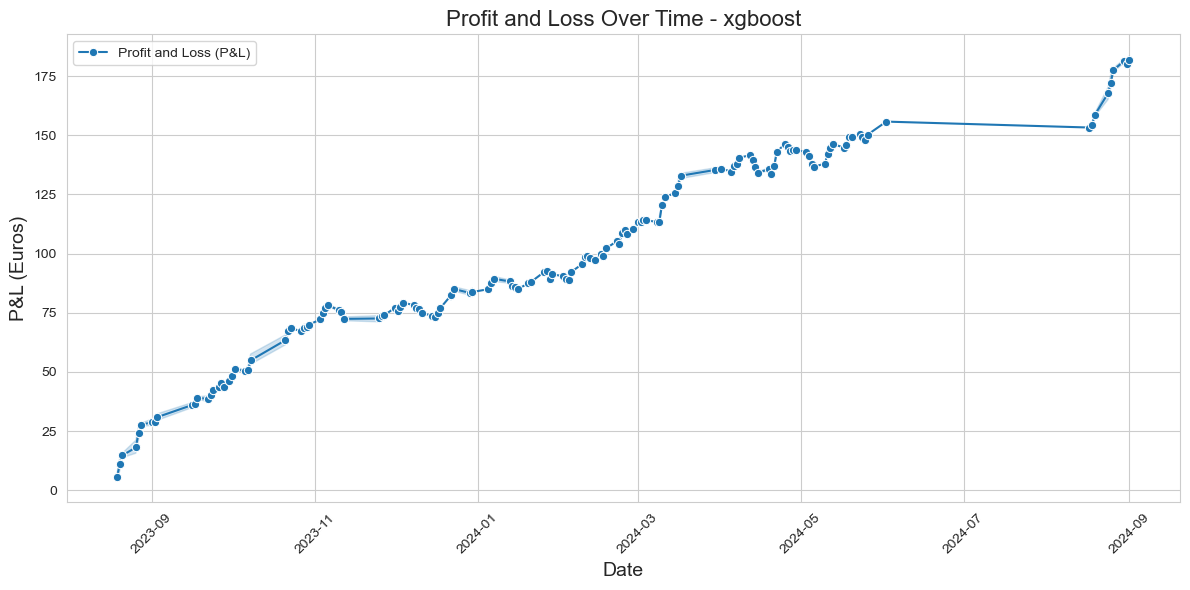

If you had placed a bet of 1 Euro on each match, starting from the first match of the 2023-2024 season and continuing until the last available match in the 2024-2025 season (for a total investment of 409 Euros), you would have achieved:
- Total profit: 182.65 Euros
- Return on Investment (ROI): 44.66%


In [12]:
#xgboost
y_pred_xgboost_improved = xgboost_improved.predict(X_2324_2425)

data_xg = data_2324_2425
data_xg['Prediction'] = y_pred_xgboost_improved

tot_data_xg = PandL(data_xg, stake=1)
profit_xg = tot_data_xg['P&L'].iloc[-1]
ROI_xg = (profit_xg / total_bet)*100
PL_xg = tot_data_xg['P&L']

tot_data_xg['Date'] = pd.to_datetime(tot_data_xg['Date'], dayfirst=True)
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(data=tot_data_xg, x='Date', y='P&L', marker='o', label='Profit and Loss (P&L)')

plt.title('Profit and Loss Over Time - xgboost', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('P&L (Euros)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

print(
    f"If you had placed a bet of 1 Euro on each match, starting from the first match of the "
    f"2023-2024 season and continuing until the last available match in the 2024-2025 season "
    f"(for a total investment of {total_bet} Euros), you would have achieved:\n"
    f"- Total profit: {profit_xg:.2f} Euros\n"
    f"- Return on Investment (ROI): {ROI_xg:.2f}%"
)

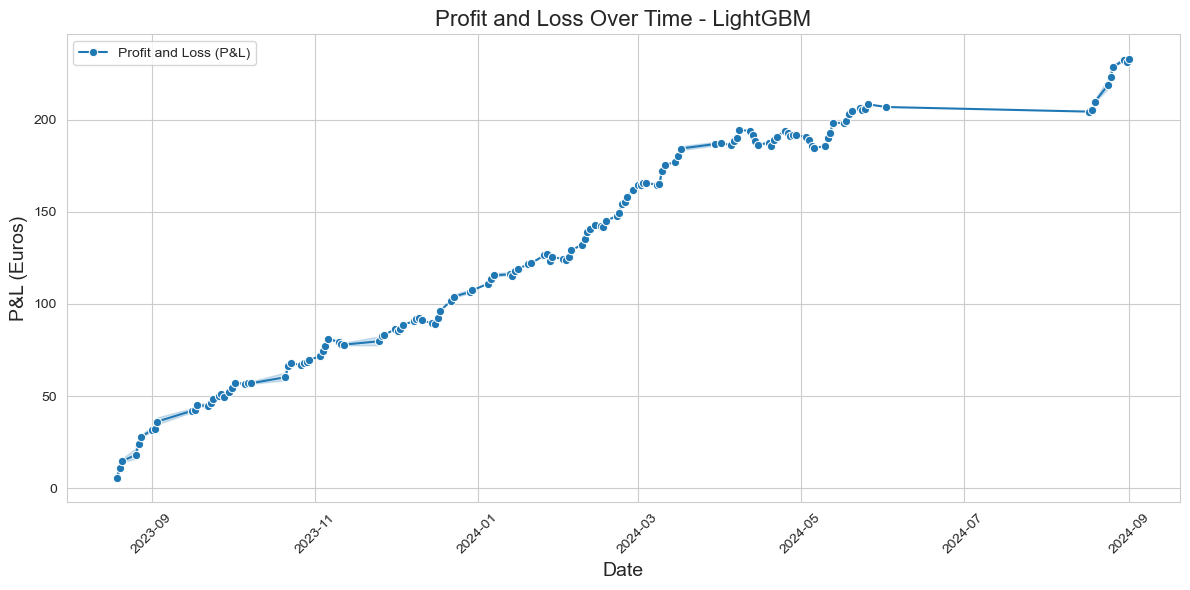

If you had placed a bet of 1 Euro on each match, starting from the first match of the 2023-2024 season and continuing until the last available match in the 2024-2025 season (for a total investment of 409 Euros), you would have achieved:
- Total profit: 233.68 Euros
- Return on Investment (ROI): 57.13%


In [13]:
#LightGBM
y_pred_lightgbm_improved = lightgbm_improved.predict(X_2324_2425)

data_l = data_2324_2425
data_l['Prediction'] = y_pred_lightgbm_improved

tot_data_l = PandL(data_l, stake=1)
profit_l = tot_data_l['P&L'].iloc[-1]
ROI_l = (profit_l / total_bet)*100
PL_l = tot_data_l['P&L']

tot_data_l['Date'] = pd.to_datetime(tot_data_l['Date'], dayfirst=True)
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(data=tot_data_l, x='Date', y='P&L', marker='o', label='Profit and Loss (P&L)')

plt.title('Profit and Loss Over Time - LightGBM', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('P&L (Euros)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

print(
    f"If you had placed a bet of 1 Euro on each match, starting from the first match of the "
    f"2023-2024 season and continuing until the last available match in the 2024-2025 season "
    f"(for a total investment of {total_bet} Euros), you would have achieved:\n"
    f"- Total profit: {profit_l:.2f} Euros\n"
    f"- Return on Investment (ROI): {ROI_l:.2f}%"
)

In [14]:
# Unique chart
combined_data = pd.DataFrame({
    'Date': dates.tolist() * 5,  # REPEAT the dates 5 times 
    'P&L': PL_lrs.tolist() + PL_nl.tolist() + PL_rm.tolist() + PL_xg.tolist() + PL_l.tolist(),
    'Model': (['Simple Logistic Regression'] * len(dates) +
              ['Elastic Net Logistic Regression'] * len(dates) +
              ['Random Forest'] * len(dates) +
              ['XGBoost'] * len(dates) +
              ['LightGBM'] * len(dates))
})

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

sns.lineplot(
    data=combined_data,
    x='Date',
    y='P&L',
    hue='Model',  # Different lines 
    marker='o'
)

plt.title('Profit and Loss Over Time by Model', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('P&L (Euros)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Model', loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()


NameError: name 'dates' is not defined

In [ ]:
# Define the data
data = {
    "Simple Logistic Regression": [303.93, "74.31%"],
    "Elastic Net Logistic Regression": [303.93, "74.31%"],
    "Random Forest": [240.08, "58.70%"],
    "XGBoost": [182.65, "44.66%"],
    "LightGBM": [233.68, "57.13%"],
}

# Create the DataFrame
df = pd.DataFrame(data, index=["Total Profit", "ROI"])

# Style the table
styled_table = (
    df.style.format(
        formatter={"Total Profit": "{:.2f}"}, na_rep=""
    )
    .set_table_styles(
        [
            {
                "selector": "thead th",
                "props": [
                    ("background-color", "#d9edf7"),
                    ("color", "#31708f"),
                    ("font-weight", "bold"),
                    ("border", "1px solid #ddd"),
                ],
            },
            {
                "selector": "tbody td",
                "props": [("border", "1px solid #ddd"), ("padding", "5px")],
            },
            {"selector": "th", "props": [("font-weight", "bold"), ("border", "1px solid #ddd")]},
        ]
    )
    .set_caption("Model Performance Metrics")
    .highlight_max(axis=1, color="lightgreen")  # Highlights max values per column
    .highlight_min(axis=1, color="lightcoral")  # Highlights min values per column
)

styled_table


## Results

From the analysis conducted, the following observations can be made:

- Although the best predictive model based on the synthetic metric (f1-weighted) is the Random Forest, the Simple Logistic Regression and Elastic Net Logistic Regression models yield better results in terms of profits and ROI at the end of the period.

- This outcome can be explained using the Confusion Matrix:
  - **Accuracy**: Logistic Regression: 239/409 vs. Random Forest: 230/409
  - **Away Wins**: Logistic Regression > Random Forest (by 2)
  - **Home Wins**: Logistic Regression > Random Forest (by 24)
  - **Draws**: Logistic Regression < Random Forest (by 17)

Despite the higher average odds for draws (suggesting potentially greater profits for the Random Forest), the superior accuracy and better prediction of home and away wins make Logistic Regression and Elastic Net Logistic Regression the better choice, providing higher profits overall.

If a similar strategy were to be implemented using a dataset closely resembling the data used for training, Elastic Net Logistic Regression would likely be the preferred choice. This model offers superior profitability compared to all other models and better handles correlated features compared to Simple Logistic Regression.


In [ ]:
# Define the confusion matrices
conf_matrix_elastic_net = np.array([[84, 9, 22],
                                     [38, 15, 71],
                                     [13, 17, 140]])

conf_matrix_random_forest = np.array([[82, 18, 15],
                                       [37, 32, 55],
                                       [27, 27, 116]])

# Define the labels
labels = ["Away Win (A)", "Draw (D)", "Home Win (H)"]

# Plot both confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Elastic Net Logistic Confusion Matrix
sns.heatmap(conf_matrix_elastic_net, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels, yticklabels=labels, cbar=False, ax=axes[0],
            annot_kws={"size": 14})  # Increase annotation font size
axes[0].set_title("Confusion Matrix: Elastic Net Logistic", fontsize=14)
axes[0].set_xlabel("Predicted Labels", fontsize=12)
axes[0].set_ylabel("Actual Labels", fontsize=12)

# Random Forest Confusion Matrix
sns.heatmap(conf_matrix_random_forest, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels, yticklabels=labels, cbar=False, ax=axes[1],
            annot_kws={"size": 14})  # Increase annotation font size
axes[1].set_title("Confusion Matrix: Random Forest", fontsize=14)
axes[1].set_xlabel("Predicted Labels", fontsize=12)
axes[1].set_ylabel("Actual Labels", fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()



## Conclusion
By all the analysis we have done, it is easy to see that it is possible to implement a strategy that beats the bookmakers.